# Whale Classifier

In [9]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [10]:
from fastai.imports import *
from fastai.transforms import *
from fastai.conv_learner import *
from fastai.model import *
from fastai.dataset import *
from fastai.sgdr import *
from fastai.plots import *

In [11]:
PATH = './data/whale/'
arch = resnet34 #resnet50
sz = 224
bs = 64

In [13]:
label_csv = f'{PATH}train.csv'

n = len(list(open(label_csv)))-1

val_idxs = get_cv_idxs(n)

# Data Transform

In [14]:
augs = [
    RandomFlip(),
    RandomLighting(0.1, 0.1),
    RandomRotate(3)
]

def get_data(sz, bs, val):
    tfms = tfms_from_model(arch, sz, aug_tfms=augs, crop_type=CropType.NO)
    data = ImageClassifierData.from_csv(PATH, 'train' ,f'{PATH}train.csv', test_name='test',
                                        val_idxs=val, tfms=tfms, bs=bs)
    return data

# Find Learning Rate

In [15]:
data = get_data(sz,bs,val_idxs)

In [16]:
learn = ConvLearner.pretrained(arch, data)

In [8]:
lrf = learn.lr_find()

 93%|█████████▎| 115/124 [00:57<00:04,  1.99it/s, loss=29.9]

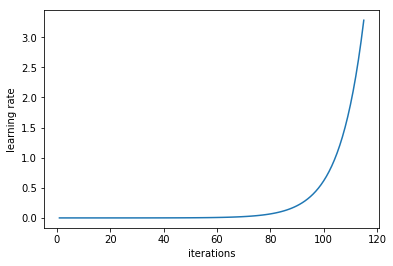

In [9]:
learn.sched.plot_lr()

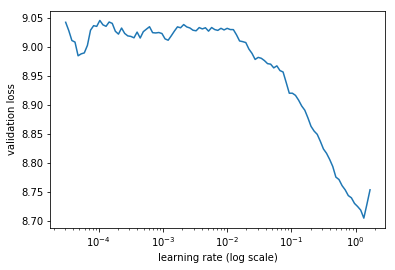

In [10]:
learn.sched.plot()

In [18]:
lr = 1e-2

In [19]:
lrs = np.array([lr/18,lr/6,lr/2])

# Improve Model

In [12]:
learn.fit(lr, 3)

epoch      trn_loss   val_loss   accuracy                   
    0      8.618667   8.105346   0.068528  
    1      8.00837    7.861185   0.080203                   
    2      7.620529   7.723955   0.082234                   


[array([7.72395]), 0.08223350257589127]

In [20]:
learn.precompute = False

In [14]:
learn.fit(lr, 3, cycle_len=1)

epoch      trn_loss   val_loss   accuracy                   
    0      7.282003   7.659969   0.084772  
    1      7.1302     7.60413    0.085279                   
    2      7.02796    7.543538   0.08934                    


[array([7.54354]), 0.08934010156066284]

In [15]:
learn.save('resnet34_224_lastlayer')

In [16]:
learn.load('resnet34_224_lastlayer')

In [21]:
learn.unfreeze()

In [19]:
learn.fit(lrs, 3, cycle_len=1, cycle_mult=2)

epoch      trn_loss   val_loss   accuracy                   
    0      7.271085   7.515188   0.084772  
    1      7.031004   7.373584   0.092893                   
    2      6.76188    7.33728    0.096447                   
    3      6.680916   7.269106   0.102538                   
    4      6.455677   7.169356   0.108629                   
    5      6.221236   7.124552   0.115736                   
    6      6.061267   7.116793   0.115228                   


[array([7.11679]), 0.11522842630517059]

In [20]:
learn.save('resnet34_224_all')

In [22]:
learn.load('resnet34_224_all')

# Increase Data Image Size

In [23]:
sz = 320

In [24]:
data = get_data(sz,bs,val_idxs)
learn.set_data(data)

In [14]:
learn.freeze()

In [15]:
learn.fit(lr, 3, cycle_len=1)

epoch      trn_loss   val_loss   accuracy                   
    0      6.395224   7.183491   0.105584  
    1      6.255886   7.109929   0.111168                   
    2      6.066776   7.053382   0.117259                   



[array([7.05338]), 0.11725888315796247]

In [16]:
learn.save('resnet34_320_last_layer')

In [17]:
learn.load('resnet34_320_last_layer')

In [25]:
learn.unfreeze()

In [21]:
learn.fit(lrs, 3, cycle_len=1, cycle_mult=2)

epoch      trn_loss   val_loss   accuracy                   
    0      6.017801   6.973367   0.12335   
    1      5.886377   6.88595    0.126396                   
    2      5.555857   6.85848    0.127411                   
    3      5.528859   6.814985   0.134518                   
    4      5.282362   6.726817   0.144162                   
    5      4.964133   6.676441   0.146193                   
    6      4.779532   6.66944    0.147208                   



[array([6.66944]), 0.147208121797155]

In [ ]:
log_preds, y = learn.TTA()
probs = np.mean(np.exp(log_preds), 0)
accuracy_np(probs, y), metrics.log_loss(y, probs)

In [22]:
learn.save('resnet34_320_all')

In [26]:
learn.load('resnet34_320_all')

# Train with Everything

In [27]:
# Move all validation data except one (due to fastai limitation) to training data
data = get_data(sz,bs,[0])
learn.set_data(data)

In [28]:
learn.fit(lrs, 3, cycle_len=1, cycle_mult=2)

epoch      trn_loss   val_loss   accuracy                   
    0      5.124953   9.404948   0.0       
    1      5.071967   9.370032   0.0                        
    2      4.896211   9.412498   0.0                        
    3      4.848767   9.310438   0.0                        
    4      4.654733   9.400867   0.0                        
    5      4.479063   9.290376   0.0                        
    6      4.444093   9.279306   0.0                        



[array([9.27931]), 0.0]

# Create Submission

In [29]:
probs, _ = learn.TTA(is_test=True)

In [45]:
probs

array([[[-10.18438,  -8.44028,  -8.71341, ...,  -8.33914, -10.95074,  -8.27512],
        [ -9.03195,  -7.86517,  -7.66707, ...,  -8.16125,  -9.31185, -10.0053 ],
        [-10.56409,  -6.65353,  -7.02999, ...,  -8.30079,  -8.52542,  -7.40936],
        ...,
        [ -8.84222,  -9.56362,  -9.93974, ...,  -9.7191 ,  -9.60596,  -9.99986],
        [-12.09411, -14.05111,  -8.56835, ...,  -9.43986, -11.72827, -11.58534],
        [ -9.92542,  -9.37016, -10.47911, ...,  -8.93056,  -7.51169,  -8.88816]],

       [[ -9.69267,  -8.46594,  -8.29192, ...,  -8.15499, -11.35465,  -8.6234 ],
        [ -8.68394,  -8.40194,  -8.61867, ...,  -9.03401, -10.09398, -10.27195],
        [-10.44207,  -6.43309,  -7.01495, ...,  -8.23721,  -8.2851 ,  -7.56605],
        ...,
        [ -8.70747,  -8.78803, -10.33865, ...,  -9.55172,  -9.55467,  -9.92232],
        [-12.37547, -14.47012,  -8.79277, ..., -10.05119, -12.28521, -11.64407],
        [ -9.56054,  -9.60481, -10.44456, ...,  -8.81558,  -7.1285 ,  -8.74425]],

In [61]:
mean_probs = np.mean(np.exp(probs), axis=0) # Average probs from TTA
probs_sorted = np.argsort(mean_probs,axis=1)[:,-5:] # Get top 5 predictions

In [62]:
probs_sorted[0]

array([ 680, 3804, 4205, 4023, 3918])

In [47]:
# Assemble our data frame
mean_probs = np.mean(probs, axis=0) # Average probs from TTA
probs_sorted = np.argsort(-mean_probs,axis=1)[:,:5] # Get top 5 predictions

In [50]:
probs_sorted[0]

array([3918, 4023, 4205, 3804,  680])

In [42]:
import dill as pickle
whale_ids2num = pickle.load(open('whale_ids2num.pkl', 'rb'))

In [43]:
fnames = [f[5:] for f in data.test_ds.fnames] # get rid of folder prefix

num2whale = [k for k,v in whale_ids2num.items()]

def probs2whale(x):
    return num2whale[int(data.classes[x])]

probs2whale = np.vectorize(probs2whale)

def join_with_spaces(arr):
    return ' '.join(arr)

whales = np.apply_along_axis(join_with_spaces, 1, probs2whale(probs_sorted))

In [44]:
df = pd.DataFrame({'Image': fnames, 'Id': whales}, columns=['Image','Id'])
df.to_csv('submission3.csv', index=False)